In [1]:
#!nvidia-smi

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [2]:
configs = {
    "batch_size" : 32,
    "max_file_count" : 2179,
    "train_file" : 7,
    "validation_file" : 3,
    "test_file" : 3,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 2,
    "scheduler_min_lr": 3e-6,
    "epoch" : 10,
    "model_name" : "LSTM7",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/66900 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30567 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/22071 [00:00<?, ?it/s]

In [3]:
torch.set_default_dtype(torch.float32)

class LSTMBlock(nn.Module) :
    def __init__(self, input_size, output_size) :
        super().__init__()
        self.LSTM = nn.LSTM(input_size,output_size,2,batch_first=True,bias=False)
        self.Dropout = nn.Dropout(p=0.2)
        self.LayerNorm = nn.LayerNorm(output_size)
    
    def forward(self, input) :
        h1,_ = self.LSTM(input)
        h2 = self.Dropout(h1)
        output = self.LayerNorm(h2)
        return output

class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 512
        self.batch_size = configs["batch_size"]
        self.layer1 = LSTMBlock(4,self.hidden_size)
        self.layer2 = nn.Linear(self.hidden_size,1,bias=False)

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1 = self.layer1(input)
        output = self.layer2(h1[:,-1,:])
        output = torch.multiply(output,0.04)
        return output


In [6]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],4))

Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         3,153,920
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    1,024
├─Linear: 1-2                            512
Total params: 3,155,456
Trainable params: 3,155,456
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         3,153,920
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    1,024
├─Linear: 1-2                            512
Total params: 3,155,456
Trainable params: 3,155,456
Non-trainable params: 0

In [7]:
try_input = torch.zeros(configs["batch_size"],configs["input_size"],4)
try_input = try_input.to(device=device)

dataset = model(try_input)

In [8]:
loss_fn = torch.nn.L1Loss()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [10]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = torch.transpose(input[:,1:5,:],1,2)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = torch.transpose(input[:,1:5,:],1,2)
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

train loss :  0.015662213607856103
val loss :  0.014612349652300018


  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

train loss :  0.015336294359032903
val loss :  0.014756570312716263


  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

train loss :  0.015257935123919158
val loss :  0.014661177288721369


  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

train loss :  0.015198188822974927
val loss :  0.014582652299718552


  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

train loss :  0.015170054299239979
val loss :  0.014595924083787109


  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

train loss :  0.015152540780452379
val loss :  0.01459062800923099


  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

train loss :  0.015145248092229713
val loss :  0.01458942178461252


  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

train loss :  0.015132119842809424
val loss :  0.014578525286596951


  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

train loss :  0.015134895235549605
val loss :  0.014578504346467125


  0%|          | 0/2091 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

train loss :  0.015129896595575022
val loss :  0.014582573707308132


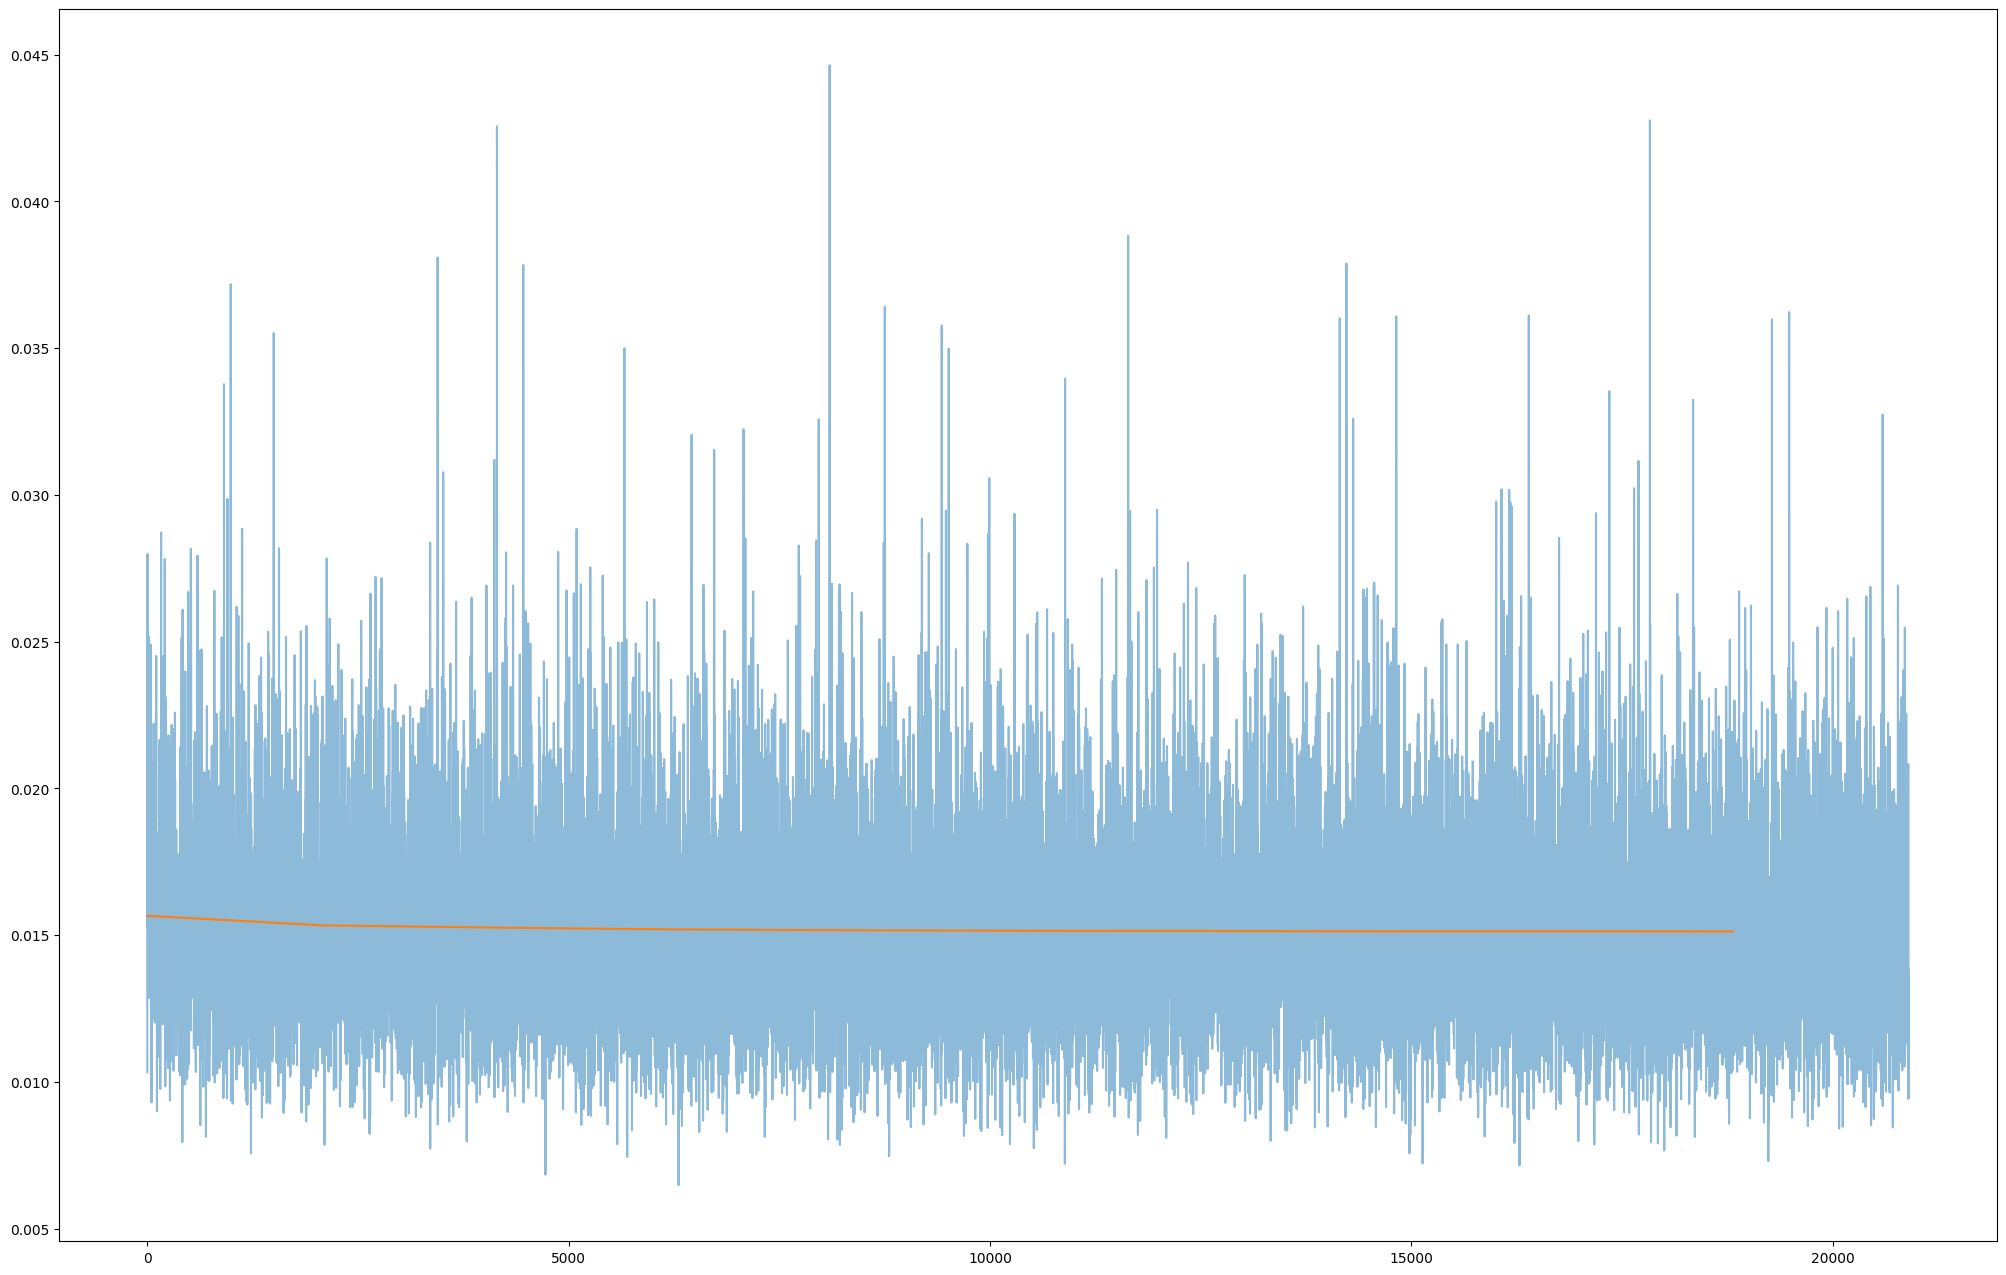

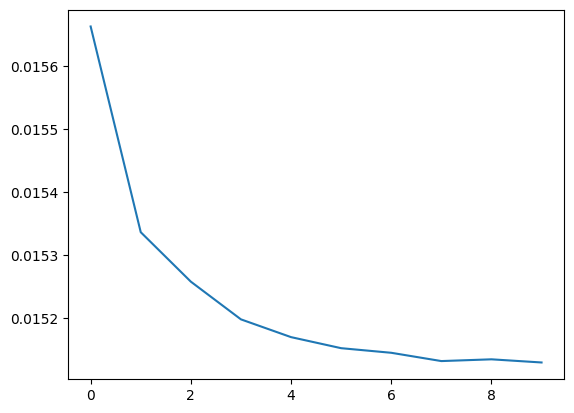

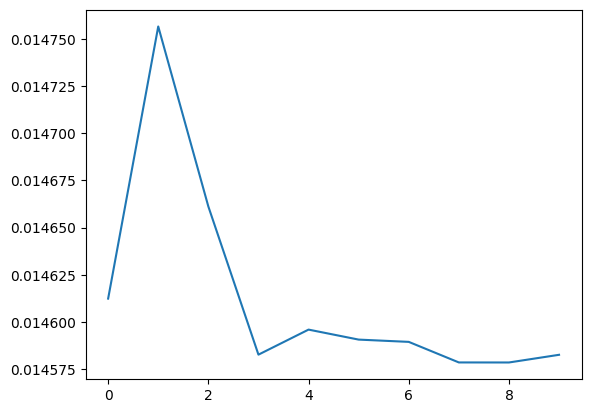

In [17]:
plt.figure(figsize=(25, 16))
plt.plot(train_losses,alpha=0.5)
plt.plot(list(range(0,len(train_losses),int(len(train_losses) / len(avarage_train_losses)))),avarage_train_losses)
plt.show()
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [18]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [4]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTMBlock(
    (LSTM): LSTM(4, 512, num_layers=2, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (layer2): Linear(in_features=512, out_features=1, bias=False)
)

In [20]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = torch.transpose(input[:,1:5,:],1,2)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/690 [00:00<?, ?it/s]

0.019084831463181143


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

0.027280904 -> -0.0012143535 **
0.00846264 -> -0.000386315 **
0.027702712 -> 4.9063656e-05 
-0.010989148 -> -0.000736163 
-0.0013822329 -> -0.0015701063 
0.01373648 -> -0.0006449992 **
-0.02346552 -> -0.00043040313 
0.016620858 -> 0.00041385012 
-0.056512143 -> -6.704496e-05 
-0.030998778 -> 0.0004715759 **
0.12525128 -> 0.00043012056 
-0.028170828 -> 0.0019278794 **
0.020202698 -> -3.6512225e-05 **
-0.0053476966 -> 3.3362245e-05 **
0.01990779 -> -0.00042318844 **
0.044965845 -> -0.00013208349 **
0.059737533 -> 0.00031266263 
0.15228924 -> -0.00077363924 **
0.15762901 -> -0.0010351033 **
0.09594127 -> 0.0035550585 
-0.02475179 -> -0.005445047 
-0.071189456 -> -0.00393995 
-0.07946418 -> -0.0019094876 
-0.06403746 -> -0.000945328 
-0.038820002 -> 0.0013520323 **
0.080042735 -> 0.0017364698 
0.058813017 -> 0.0040361728 
-0.013692594 -> -0.0013406056 
-0.020427812 -> 2.1743122e-05 **
0.014897877 -> -0.00045848207 **
0.011029468 -> 0.00076531136 
0.044690236 -> 0.0011577292 
-0.021202233 -

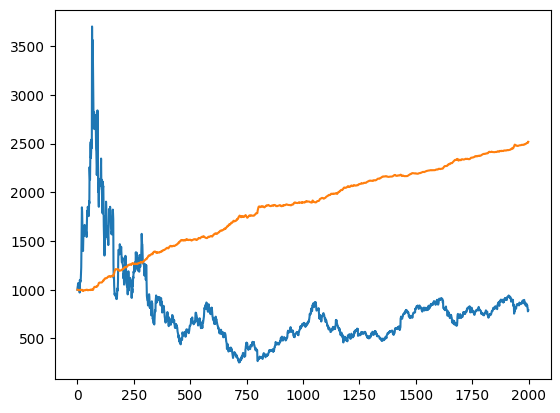

In [5]:
plot_dataset = StockDatasetLogReturn(["./data/A.csv"],configs["input_size"],1)

real = [1000]
predict = [1000]
price = 1000

feed_queue = list(range(plot_dataset.__len__()))
rd.shuffle(feed_queue)
predict_output = []
real_output = []
with torch.no_grad() : 
    for i in tqdm(range(0,plot_dataset.__len__(),configs["batch_size"])) :
        close_price_input = []
        close_price_target = []
        for j in range(configs["batch_size"]) :
            input,target = plot_dataset.__getitem__(i + j)
            close_price_input.append(torch.transpose(input[None,1:5,:],1,2))
            close_price_target.append(target[4].numpy())
        close_price_input = torch.cat(close_price_input).to(device)

        output = best_model(close_price_input)
        output = output.to(torch.device("cpu")).numpy()

        for j in range(configs["batch_size"]) :
            real_output.append(math.exp(close_price_target[j][0]))
            predict_output.append(math.exp(output[j][0]))
            print(close_price_target[j][0],"->",output[j][0],"**" if close_price_target[j][0] * output[j][0] < 0 else "")

for i in range(len(predict_output)) :
    predict.append(predict[-1] * predict_output[i])
    real.append(real[-1] * real_output[i])

plt.plot(real[0:2000])
plt.plot(predict[0:2000])
plt.show()

In [6]:
print(np.mean((np.log(np.array(real_output)) * np.log(np.array(predict_output))) > 0))

0.5115559895833334


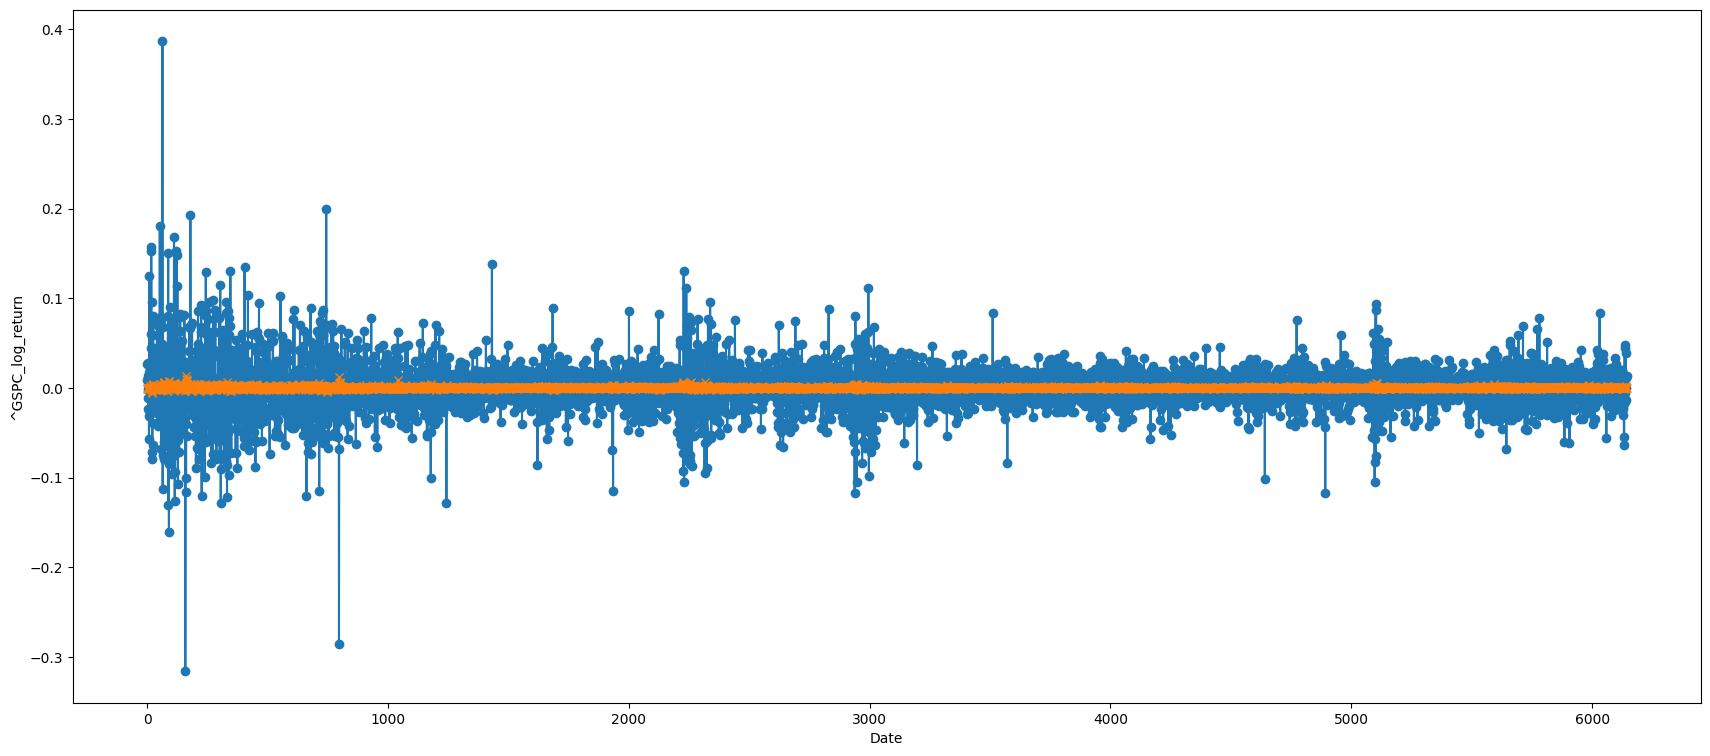

In [22]:
log_real_output = list(map(math.log,real_output))
log_predict_output = list(map(math.log,predict_output))
plt.figure(figsize=(21, 9))
plt.plot(log_real_output, label="Actual", marker='o')
plt.plot(log_predict_output, label= "Predicted",marker='x')
plt.xlabel('Date')
plt.ylabel('^GSPC_log_return')
plt.show()

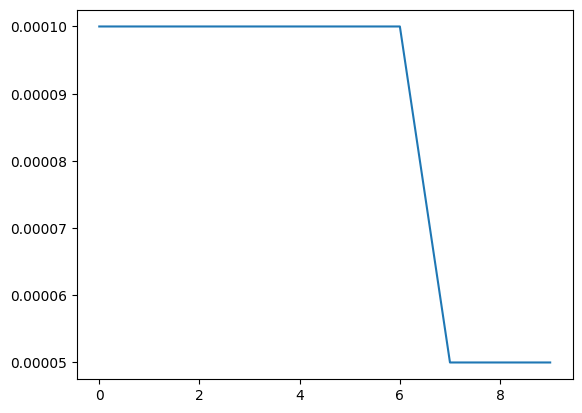

In [23]:
plt.plot(learning_rates)
plt.show()